In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import glob
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
path = "bug_6.png"
from src.godr.backend.recognizer import Recognizer
rec = Recognizer()

In [3]:
def to_RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
def canny_edges(img_gray):
    CANNY_THRESHOLD1 = 100
    CANNY_THRESHOLD2 = 200
    return cv2.Canny(img_gray, CANNY_THRESHOLD1, CANNY_THRESHOLD2)

In [5]:
def all_lines(edges, hough_threshold, gap=0):
    HOUGH_RHO = 1
    HOUGH_THETA = np.pi / 180
    MIN_LINE_LEN_COEFF = 0.75
    size = min(edges.shape[0:2])
    lines = cv2.HoughLinesP(edges, rho=HOUGH_RHO, theta=HOUGH_THETA, threshold=hough_threshold,
                            minLineLength=size * MIN_LINE_LEN_COEFF, maxLineGap=size * 0.1)
    if lines is None:
        return None
    return np.reshape(lines, (lines.shape[0], lines.shape[2]))   

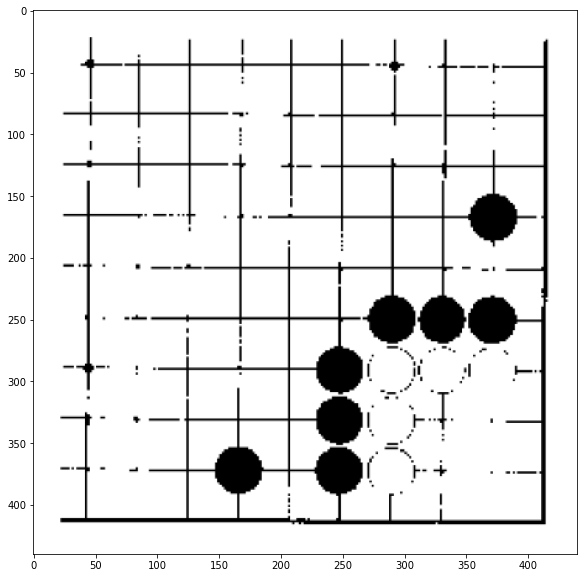

In [6]:
img = cv2.imread(path, cv2.IMREAD_COLOR)
plt.imshow(to_RGB(img))
plt.show()

In [7]:
def align_board(board_img):
    HOUGH_LOW_THRESHOLD = 40
    edges = canny_edges(board_img)
    # Find all lines
    lines = all_lines(edges, HOUGH_LOW_THRESHOLD)
    if (lines is None):
        return edges, None

    # Get all angles
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line
        angle = np.arctan((y2 - y1) / (x2 - x1)) if x1 != x2 else np.arctan(np.sign(y2 - y1) * np.inf)
        angles.append(angle)

    # Get 2 main angles
    angles.sort()
    new_group = np.diff(angles) < 0.1
    groups = []
    i = 0
    while i < len(angles):
        groups.append([])
        groups[-1].append(angles[i])
        while i + 1 < len(angles) and new_group[i]:
            i += 1
            groups[-1].append(angles[i])
        i += 1
    if len(groups) < 2:
        raise Exception
    groups.sort(key=lambda x: len(x), reverse=True)
    angle_1 = np.median(groups[0])
    angle_2 = np.median(groups[1])

    # Make affine transform to align board
    if abs(angle_1) < abs(angle_2):
        angle_h, angle_v = angle_1, angle_2
    else:
        angle_h, angle_v = angle_2, angle_1
    pts2 = np.float32([[0, 0],
                       [1, 0],
                       [0, np.sign(angle_v)]])
    pts1 = np.float32([[0, 0],
                       [np.cos(angle_h), np.sin(angle_h)],
                       [np.cos(angle_v), np.sin(angle_v)]])
    affine_t = cv2.getAffineTransform(pts1, pts2)
    rows, cols = edges.shape[0:2]
    transformed_board_img = cv2.warpAffine(board_img, affine_t, (cols, rows),
                                       borderMode=cv2.BORDER_REPLICATE)
    return transformed_board_img

In [8]:
def get_aligned_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return align_board(img)

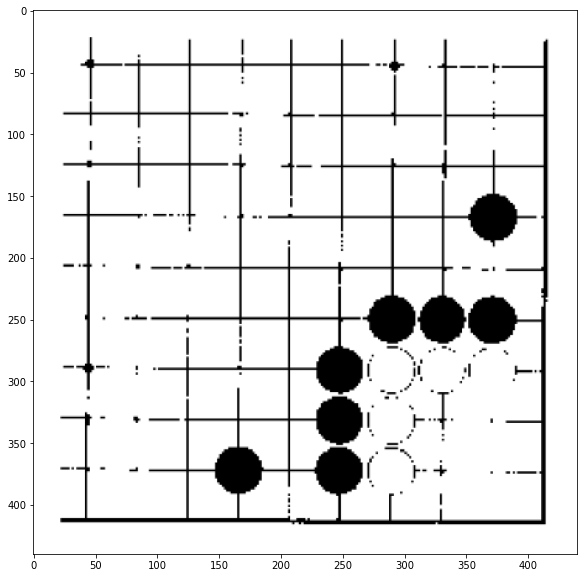

In [9]:
plt.imshow(to_RGB(get_aligned_img(path)))
plt.show()

In [10]:
edges = canny_edges(get_aligned_img(path))

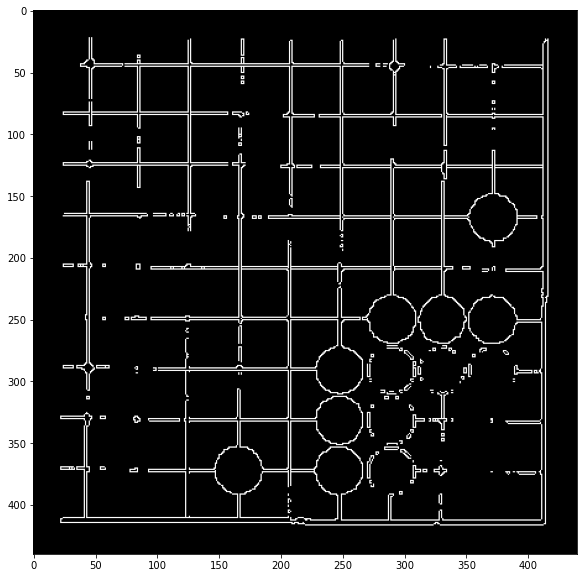

In [11]:
plt.imshow(to_RGB(edges))
plt.show()

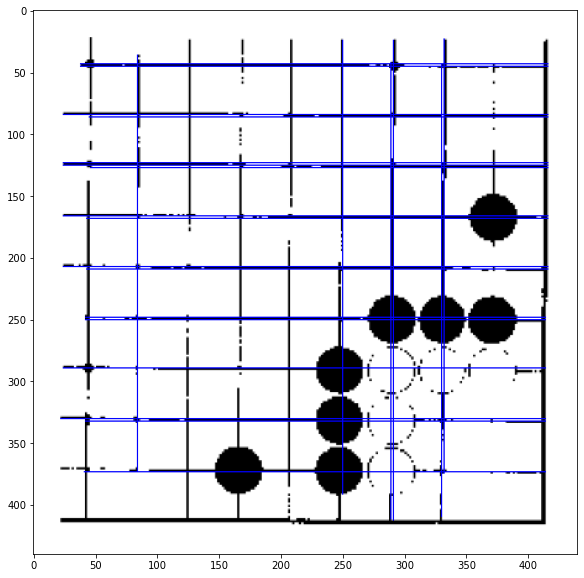

In [12]:
lines = all_lines(edges, 10)
img = cv2.imread(path, cv2.IMREAD_COLOR)
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.imshow(to_RGB(img))
plt.show()

In [13]:
def verticals_horizontals(img_gray, hough_threshold):
    VERTICAL_TAN_MIN = 50
    HORIZONTAL_TAN_MAX = 0.02
    MIN_DIST_COEFF = 0.025

    # Find all lines
    lines = all_lines(edges, hough_threshold)
    if (lines is None):
        return np.array([]), np.array([])

    # Divide the lines into verticals and horizontals
    v_lines = []
    h_lines = []
    for line in lines:
        x1, y1, x2, y2 = line
        if x1 == x2:
            line[1] = min(y1, y2)
            line[3] = max(y1, y2)
            v_lines.append(line)
        else:
            slope = (y2 - y1) / (x2 - x1)
            if abs(slope) > VERTICAL_TAN_MIN:
                line[1] = min(y1, y2)
                line[3] = max(y1, y2)
                line[0] = line[2] = round(np.mean([x1, x2]))
                v_lines.append(line)
            elif abs(slope) < HORIZONTAL_TAN_MAX:
                line[0] = min(x1, x2)
                line[2] = max(x1, x2)
                line[1] = line[3] = round(np.mean([y1, y2]))
                h_lines.append(line)

    # Sort lines
    v_lines = np.array(sorted(v_lines, key=lambda line: line[0]))
    h_lines = np.array(sorted(h_lines, key=lambda line: line[1]))

    # Merge close lines
    size =  min(edges.shape[0:2])
    min_dist = size * MIN_DIST_COEFF
    return merge_lines(v_lines, True, min_dist), merge_lines(h_lines, False, min_dist)

In [14]:
def merge_lines(lines, is_vertical, min_dist):
    
    if lines.shape[0] == 0:                                                                
        return np.array([])                                                                
                                                                                       
    ind = 0 if is_vertical else 1                                                          
    is_close = np.diff(lines, axis=0)[:, ind] <= min_dist                                  
    merged_lines = []                                                                      
    i = 0                                                                                  
    while i < lines.shape[0]:                                                              
        close_lines = [lines[i]]                                                           
        while i + 1 < lines.shape[0] and is_close[i]:                                      
            i += 1                                                                         
            close_lines.append(lines[i])                                                   
        close_lines = np.array(close_lines)                                                
        if is_vertical:                                                                    
            x = round(np.mean(close_lines[:, ind]))                                        
            merged_line = [x, np.amin(close_lines[:, 1]), x, np.amax(close_lines[:, 3])]   
        else:                                                                              
            y = round(np.mean(close_lines[:, ind]))                                        
            merged_line = (np.amin(close_lines[:, 0]), y, np.amax(close_lines[:, 2]), y)   
        merged_lines.append(merged_line)                                                   
        i += 1                                                                             
                                                                                           
    return np.array(merged_lines)                                                          

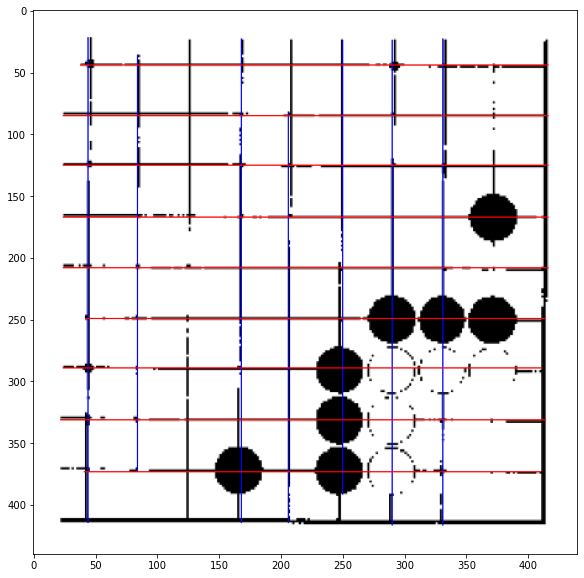

In [15]:
v_lines, h_lines =  verticals_horizontals(edges, 69)
img = get_aligned_img(path)
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
plt.imshow(to_RGB(img))
plt.show()


In [16]:
def lines_recognition(img_gray):
    HOUGH_LOW_THRESHOLD = 40
    HOUGH_THRESHOLD_STEP = 10
    # Find some very clear lines
    hough_threshold = min(edges.shape[0:2])
    cell_size = 0
    while hough_threshold > HOUGH_LOW_THRESHOLD:
        clear_v_lines, clear_h_lines = verticals_horizontals(edges, hough_threshold)
        if (len(clear_v_lines) > 3) and (len(clear_h_lines) > 3):
            dists_x = np.diff(clear_v_lines[:, 0])
            dists_y = np.diff(clear_h_lines[:, 1])
            cell_size_1 = np.amin(dists_x)
            cell_size_2 = np.amin(dists_y)
            cell_size = min(cell_size_1, cell_size_2)
            if cell_size / max(cell_size_1, cell_size_2) > 0.9:
                dists = np.concatenate([dists_x, dists_y])
                cell_size = np.mean(dists[np.round(dists / cell_size) == 1])
                break
        hough_threshold -= HOUGH_THRESHOLD_STEP
    if cell_size == 0:
        return [], []
    # Find less clear lines
    while hough_threshold > HOUGH_LOW_THRESHOLD:
        hough_threshold -= HOUGH_THRESHOLD_STEP
        clear_v_lines, clear_h_lines = verticals_horizontals(edges, hough_threshold)
        if (len(clear_v_lines) <= 1) or (len(clear_h_lines) <= 1):
            hough_threshold += HOUGH_THRESHOLD_STEP
            break
        dists_x = np.diff(clear_v_lines[:, 0])
        dists_y = np.diff(clear_h_lines[:, 1])
        dists = np.concatenate([dists_x, dists_y])
        fracs = np.modf(dists / cell_size)[0]
        ints = np.round(dists / cell_size)
        err = 0.9 - 0.15 * ints
        err[ints >= 3] = 0.5
        if np.any(np.logical_and(fracs < err, fracs > 1 - err)):
            hough_threshold += HOUGH_THRESHOLD_STEP
            break
        cell_size = np.mean(dists[ints == 1])
    clear_v_lines, clear_h_lines = verticals_horizontals(edges, hough_threshold)
    print(hough_threshold)
    # Add unclear line
                                                              
    # Calculate cell_size
    dists_x = np.diff(clear_v_lines[:, 0])
    dists_y = np.diff(clear_h_lines[:, 1])
    dists = np.concatenate([dists_x, dists_y])
    cell_size = np.mean(dists[np.round(dists / cell_size) == 1])
                        
    # Calculate length of unclear lines
    x_min, start_x = np.min(clear_h_lines[:, 0]), np.max(clear_h_lines[:, 0]),
    x_max, end_x = np.max(clear_h_lines[:, 2]), np.min(clear_h_lines[:, 2])
    y_min, start_y = np.min(clear_v_lines[:, 1]), np.max(clear_v_lines[:, 1])
    y_max, end_y = np.max(clear_v_lines[:, 3]), np.min(clear_v_lines[:, 3])
                        
    def add_unclear_lines(clear_lines, is_vertical, min_coord, max_coord, start, end):
        ind = 0 if is_vertical else 1
        lines = []
        coords = np.concatenate([[min_coord], clear_lines[:, ind], [max_coord]])
        dists = np.diff(coords)
        num_lines = (dists / cell_size).astype(int)
        num_lines[np.modf(dists / cell_size)[0] > 0.8] += 1
        num_lines[1:-1][num_lines[1:-1] != 0] -= 1
        for i in range(1, coords.size):
            for j in range(1, num_lines[i - 1] + 1):
                if i == coords.size - 1:
                    coord = coords[i - 1] + np.round(j * cell_size)
                elif i == 1:
                    coord = coords[i] - np.round((num_lines[0] + 1 - j) * cell_size)
                else:
                    coord = coords[i] - np.round((num_lines[i - 1] + 1 - j) * dists[i - 1] / (num_lines[i - 1] + 1))
                new_line = [coord, start, coord, end] if is_vertical else [start, coord, end, coord]
                lines.append(new_line)
            if i != coords.size - 1:
                lines.append(clear_lines[i - 1])
        return np.array(lines).astype(int)
    
    v_lines = add_unclear_lines(clear_v_lines, True, x_min, x_max, start_y, end_y)
    h_lines = add_unclear_lines(clear_h_lines, False, y_min, y_max, start_x, end_x)
    return v_lines, h_lines

40


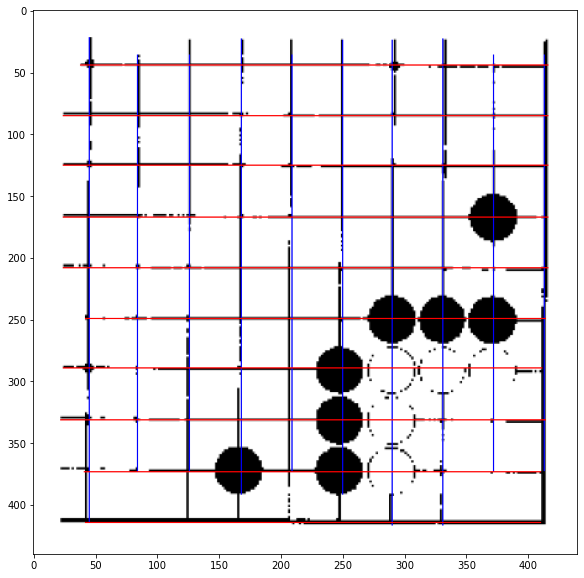

In [17]:
v_lines, h_lines = lines_recognition(edges)
img = get_aligned_img(path)
for line in v_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
for line in h_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
plt.imshow(to_RGB(img))
plt.show() 

In [18]:
def get_cell_size(v_lines, h_lines):
    return round(np.mean([(np.ptp(v_lines[:, 0]) / (v_lines.shape[0] - 1)),
                          (np.ptp(h_lines[:, 1]) / (h_lines.shape[0] - 1))]))

In [19]:
def find_intersections(v_lines, h_lines):
    return np.array(np.meshgrid(v_lines[:, 0], h_lines[:, 1])).T

In [20]:
intersections = rec.find_intersections(v_lines, h_lines)

In [21]:
cell_size = rec.get_cell_size(v_lines, h_lines)
cell_size

41

In [22]:
 def transform_for_nn(board_img, cell_size):
    block_size = 2 * cell_size + 1
    board_img_gray = cv2.cvtColor(board_img, cv2.COLOR_BGR2GRAY)
    board_img_bw = cv2.adaptiveThreshold(board_img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
                                         block_size , 0)
    board_img_bordered = cv2.copyMakeBorder(board_img_bw, cell_size, cell_size, cell_size, cell_size,
                                            borderType=cv2.BORDER_CONSTANT, value=255)
    return board_img_bordered

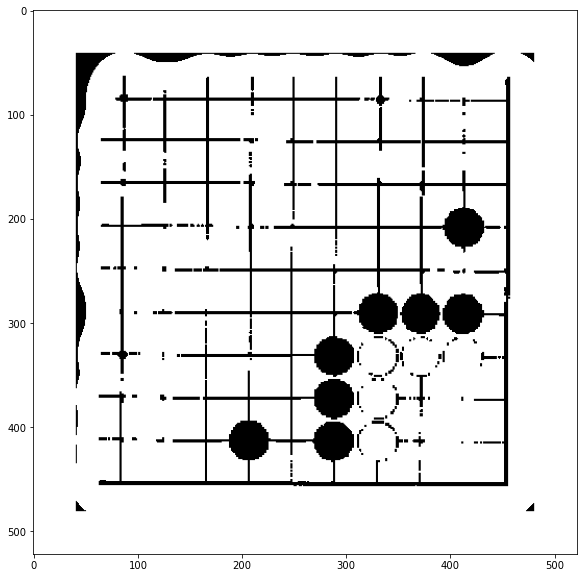

In [23]:
img = transform_for_nn(get_aligned_img(path), cell_size)
plt.imshow(to_RGB(img))
plt.show() 

In [24]:
import onnxruntime


In [25]:
model = onnxruntime.InferenceSession("src/godr/backend/models/model-2.onnx")

In [26]:
def transform(img):
    img = img.astype(np.float32) / 255
    img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_LINEAR)
    img = (img - 0.5) / 0.5
    img = np.expand_dims(img, axis=[0, 1])
    return img

In [27]:
def CNN_stones(img_gray, cell_size, intersections):
    cell_size_multiplier = 0.6
    delta = int(cell_size * cell_size_multiplier)
    white_stones = []
    black_stones = []
    for i in range(intersections.shape[0]):
        for j in range(intersections.shape[1]):
            y = intersections[i][j][0]
            x = intersections[i][j][1]
            point_img = img_gray[max(x - delta, 0): min(x + delta, img_gray.shape[0]),
                                 max(y - delta, 0): min(y + delta, img_gray.shape[1])]
            data = transform(point_img)
            input = {model.get_inputs()[0].name: data}
            output = model.run(None, input)[0]
            pred = np.argmax(output, axis = 1)
            if pred == 0:
                white_stones.append((i , j))
            elif pred == 1:
                black_stones.append((i , j))
    return white_stones, black_stones
           

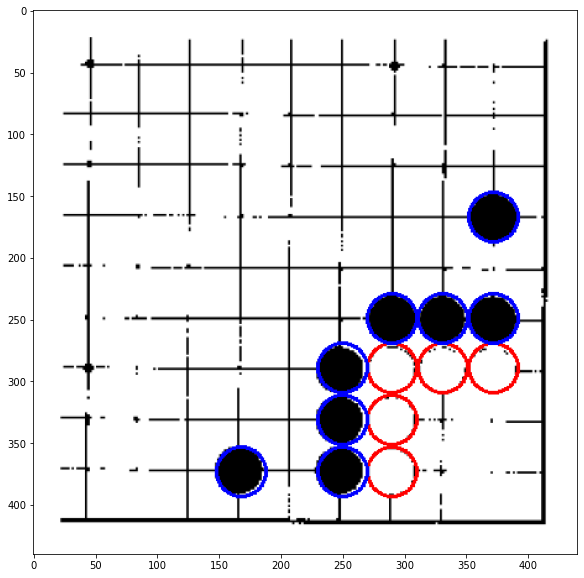

In [28]:
white_stones, black_stones = CNN_stones(img, cell_size, intersections + cell_size)
radius = cell_size//2

img = get_aligned_img(path)
for loc_stone in white_stones:
    stone = intersections[loc_stone]
    cv2.circle(img ,(stone[0],stone[1]), radius,(0,0,255),2)
for loc_stone in black_stones:
    stone = intersections[loc_stone]
    cv2.circle(img ,(stone[0],stone[1]), radius,(255,0,0),2)

plt.imshow(to_RGB(img))
plt.show()

In [29]:
def find_edges(v_lines, h_lines, stones, cell_size):

        MIN_EDGE_COEFF = 0.3
        up_line_stones = []
        down_line_stones = []
        left_line_stones = []
        right_line_stones = []
        for stone in stones:
            x, y = stone
            if y == 0:
                up_line_stones.append(x)
            if y == len(h_lines) - 1:
                down_line_stones.append(x)
            if x == 0:
                left_line_stones.append(y)
            if x == len(v_lines) - 1:
                right_line_stones.append(y)
        up_line_free = np.delete(np.arange(len(v_lines)), up_line_stones)
        down_line_free = np.delete(np.arange(len(v_lines)), down_line_stones)
        left_line_free = np.delete(np.arange(len(h_lines)), left_line_stones)
        right_line_free = np.delete(np.arange(len(h_lines)), right_line_stones)

        def is_edge(edge_coord, line_ends, flag):
            diff = edge_coord - line_ends if flag else line_ends - edge_coord
            return np.sum(diff > cell_size * MIN_EDGE_COEFF) < np.ceil(len(line_ends) / 5)

        up_edge = is_edge(h_lines[0][1], v_lines[up_line_free, 1], True)
        print(h_lines[-1][1], v_lines[down_line_free, 3])
        down_edge = is_edge(h_lines[-1][1], v_lines[down_line_free, 3], False)
        left_edge = is_edge(v_lines[0][0], h_lines[left_line_free, 0], True)
        right_edge = is_edge(v_lines[-1][0], h_lines[right_line_free, 2], False)

        return up_edge, down_edge, left_edge, right_edge

414 [414 372 372 391 372 391 416 416 372 372]


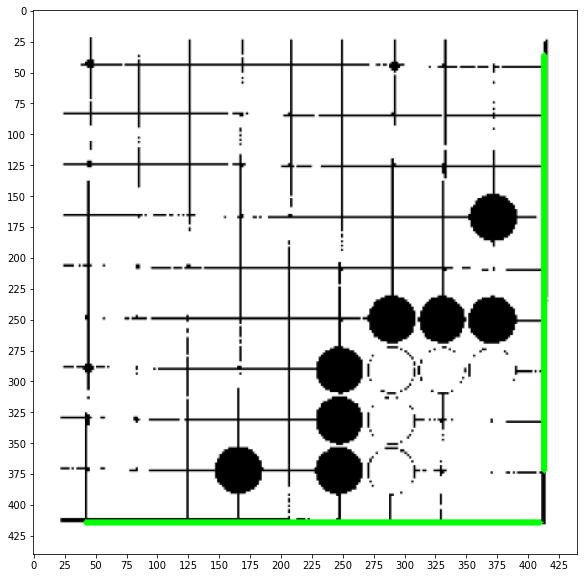

In [30]:
img = get_aligned_img(path)
up_edge, down_edge, left_edge, right_edge = find_edges(v_lines, h_lines, white_stones + black_stones, cell_size)
if up_edge:
    line = h_lines[0]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
if down_edge:
    line = h_lines[-1]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
if left_edge:
    line = v_lines[0]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
if right_edge:
    line = v_lines[-1]
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 3)
plt.imshow(to_RGB(img))
plt.yticks(np.arange(0, img.shape[0], 25))
plt.xticks(np.arange(0, img.shape[1], 25))
plt.show() 